In [1]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import os
import pickle
import lzma
import torch
from metadrive import MetaDriveEnv
from concurrent.futures import ProcessPoolExecutor
from utils.env import State, Transition, Action, next_state, normalize_angle, get_metadrive_state, state_batch_to_tensor, action_batch_to_tensor
from utils.transition_model_def import TransitionModel, transition_model_train_batch
from utils.model import set_lr
from torch.utils.data import TensorDataset, DataLoader
import itertools
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
def generate_2d_velocity(rng: np.random.Generator, v:float) -> tuple[float, float]:
    """
    Generates a random 2D velocity vector with a magnitude between 0 and v
    """
    mag = rng.uniform(0, v)
    heading = rng.uniform(-np.pi, np.pi)
    return mag * np.cos(heading), mag * np.sin(heading)

def gen_random_state_action(rng: np.random.Generator) -> tuple[State, Action]:
    """
    Generates a random state with probabilities that are similar to that are found in the waymo dataset
    """
    if rng.uniform(0, 1) < 0.5:
        # parked 
        vel = generate_2d_velocity(rng, 1)
        heading = rng.uniform(-np.pi, np.pi)
        action = Action(rng.uniform(-1, 1), rng.normal(0, 0.1))
    else:
        # moving
        vel = generate_2d_velocity(rng, 35)
        heading = normalize_angle(np.arctan2(vel[1], vel[0]) + rng.normal(0, 0.2))
        action = Action(rng.normal(0, 0.3), rng.normal(0.2, 0.3))

    return State(heading=heading, velocity=vel), action

def generate_data(n: int, thread_id: int) -> list[Transition]:
    rng = np.random.default_rng(thread_id)
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[Transition] = []
    for _ in range(n):
        s0, a = gen_random_state_action(rng)
        s1 = next_state(env, s0, a)
        dataset.append(Transition(s0, a, s1))
    env.close()
    return dataset

In [3]:
NUM_SCENARIOS = 500_000
MAX_WORKERS = 16

transition_data: list[Transition] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(NUM_SCENARIOS, MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    for i in range(leftover_size):
        n_scenarios_per_worker[i] += 1

    # generate thread ids
    thread_ids = list(range(MAX_WORKERS))

    # Generate the data in parallel
    for batch in executor.map(generate_data, n_scenarios_per_worker, thread_ids):
        transition_data.extend(batch)

[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Sensors: []

In [4]:
# save data
if not os.path.exists("./data/transition_data.pkl.xz"):
    with lzma.open("./data/transition_data.pkl.xz", "wb") as f:
        pickle.dump(transition_data, f)

: 

In [3]:
# load data
if not "transition_data" in locals():
    with lzma.open("./data/transition_data.pkl.xz", "rb") as f:
        transition_data: list[Transition] = pickle.load(f)

In [4]:
# 90:10 train-validation split
transition_train_data = transition_data[:int(len(transition_data)*0.9)]
transition_validation_data = transition_data[int(len(transition_data)*0.9):]

In [5]:
print("train data size:", len(transition_train_data))
print("validation data size:", len(transition_validation_data))

train data size: 450000
validation data size: 50000


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
tm_train_dataset = TensorDataset(
    state_batch_to_tensor([t.state for t in transition_train_data], torch.device("cpu")),
    action_batch_to_tensor([t.action for t in transition_train_data], torch.device("cpu")),
    state_batch_to_tensor([t.next_state for t in transition_train_data], torch.device("cpu")),
)
tm_train_loader = DataLoader(tm_train_dataset, batch_size=8192)
tm_train_iter = itertools.cycle(iter(tm_train_loader))

tm = TransitionModel().to(device)

tm_optimizer = torch.optim.AdamW(tm.parameters(), lr=1e-3)

tm_step = 0
tm_losses = []

In [20]:
TRAIN_EPOCHS = 20_000
while tm_step < TRAIN_EPOCHS:
    # take up to n from the data buffer
    s0_batch, a_batch, s1_batch = next(tm_train_iter)

    # train
    loss = transition_model_train_batch(tm, tm_optimizer, s0_batch, a_batch, s1_batch)
    tm_losses.append(loss)
    tm_step += 1
    if tm_step % 1000 == 0:
        # print average loss over the last 1000 steps
        loss = np.mean(tm_losses[-1000:])
        print(f"Step: {tm_step}, Loss: {loss:.6f}")


Step: 16000, Loss: 0.000287
Step: 17000, Loss: 0.000250
Step: 18000, Loss: 0.000254
Step: 19000, Loss: 0.000210
Step: 20000, Loss: 0.000202


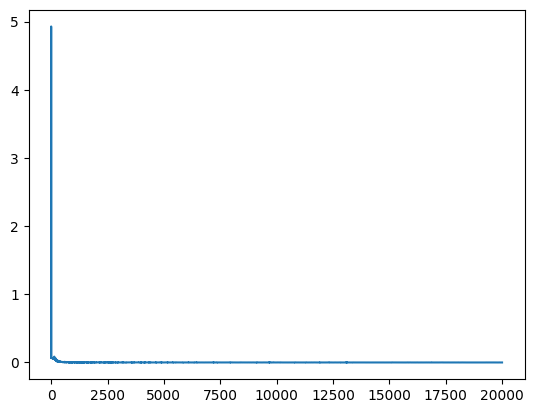

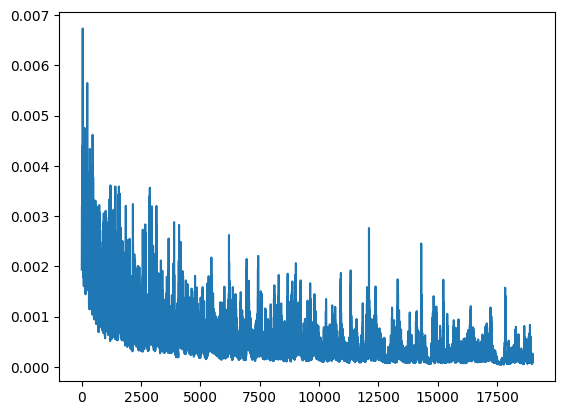

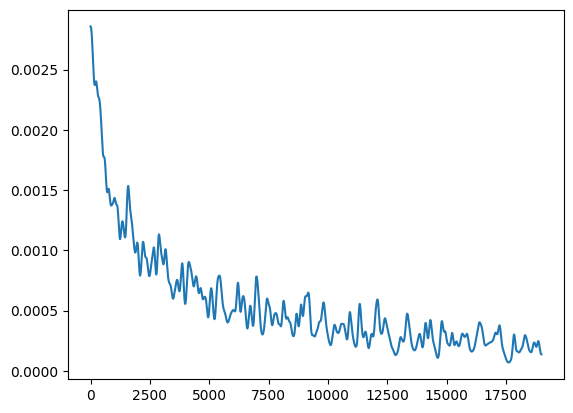

In [24]:
# Plot the losses over training
plt.plot(list(range(len(tm_losses))), tm_losses, label='MM')
plt.show()

latter_training = tm_losses[1000:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

# denoise
latter_training_denoised = gaussian_filter1d(latter_training, sigma=50)
plt.plot(list(range(len(latter_training_denoised))), latter_training_denoised, label='MM')
plt.show()

In [7]:
# load tm
if 'tm' not in locals():
    tm = TransitionModel().to(device)
    tm.load_state_dict(torch.load('data/tm.pth'))

In [27]:
# save tm
if not os.path.exists('data/tm.pth'):
    torch.save(tm.state_dict(), 'data/tm.pth')

: 

In [8]:
s0_batch = [t.state for t in transition_train_data]
s1_batch = [t.next_state for t in transition_train_data]
a_batch = [t.action for t in transition_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = tm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].detach().cpu().numpy()
loss_y = loss[:, 1].detach().cpu().numpy()
loss_theta = (loss[:, 2] + loss[:, 3]).detach().cpu().numpy()

print("training loss", loss.mean().item())

training loss 0.00016166646673809737


In [9]:
s0_batch = [t.state for t in transition_validation_data]
s1_batch = [t.next_state for t in transition_validation_data]
a_batch = [t.action for t in transition_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = tm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].detach().cpu().numpy()
loss_y = loss[:, 1].detach().cpu().numpy()
loss_theta = (loss[:, 2] + loss[:, 3]).detach().cpu().numpy()

print("validation loss", loss.mean().item())

validation loss 0.00018890098726842552


: 

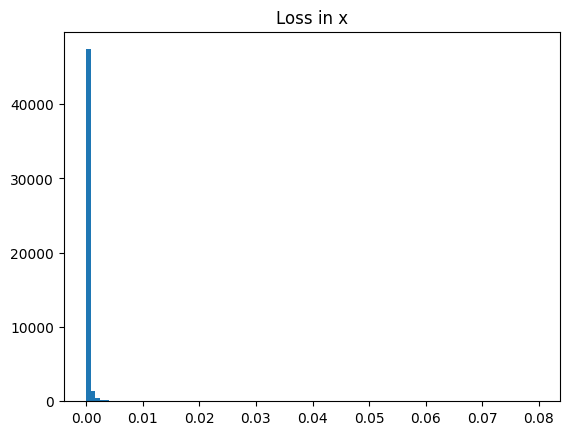

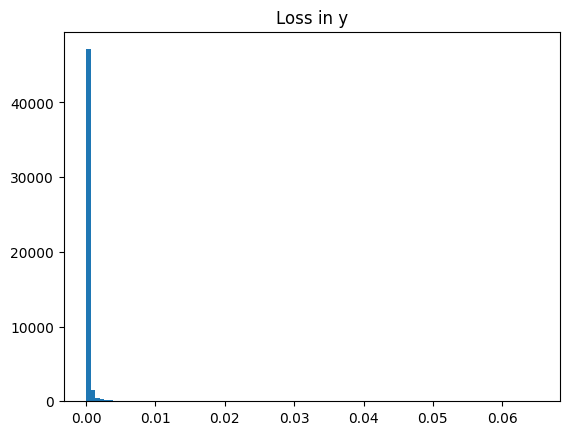

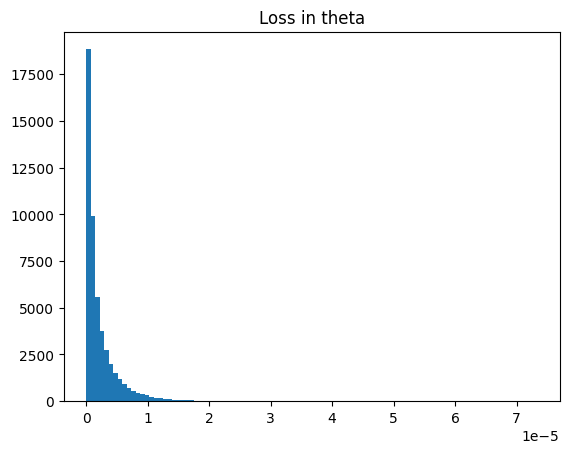

In [16]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()

In [25]:
# identify outliers
outlier_threshold = 0.01

throttles = []
steers = []
speeds = []

# plot outliers
for i, (lx, ly, lt) in enumerate(zip(loss_x, loss_y, loss_theta)):
    if lx > outlier_threshold or ly > outlier_threshold or lt > outlier_threshold:
        throttles.append(a_batch[i].throttle)
        steers.append(a_batch[i].steer)
        speeds.append(np.linalg.norm(s0_batch[i].velocity))

In [26]:
len(throttles)

433

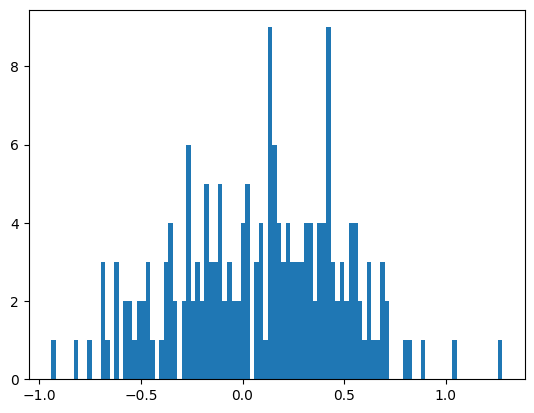

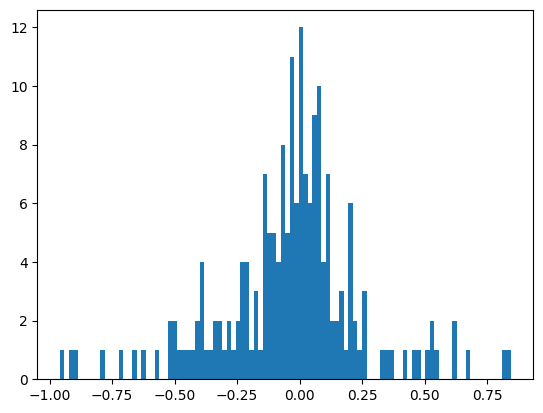

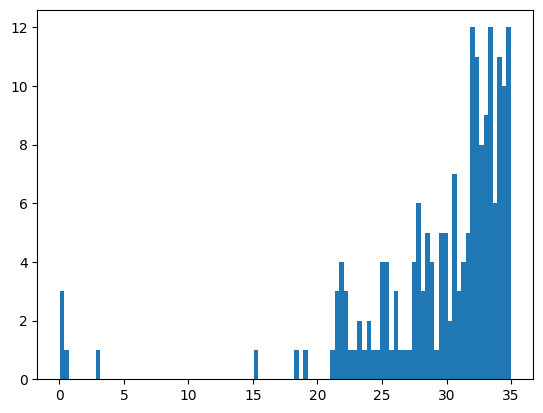

In [19]:
plt.hist(throttles, bins=100)
plt.show()
plt.hist(steers, bins=100)
plt.show()
plt.hist(speeds, bins=100)
plt.show()

In [37]:
throttles_normal = [a.throttle for a in a_batch]
steers_normal = [a.steer for a in a_batch]
speeds_normal = [np.linalg.norm(s.velocity) for s in s0_batch]

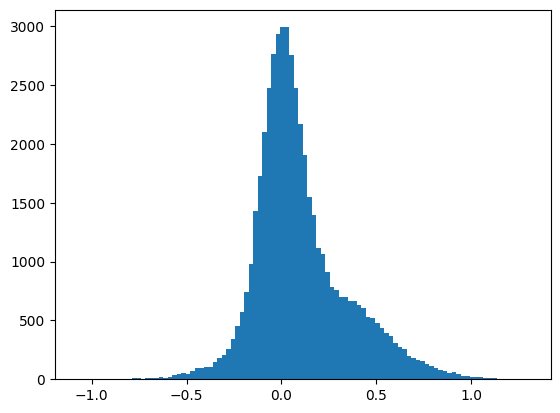

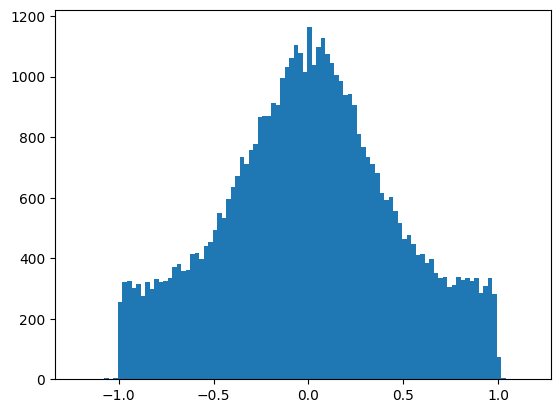

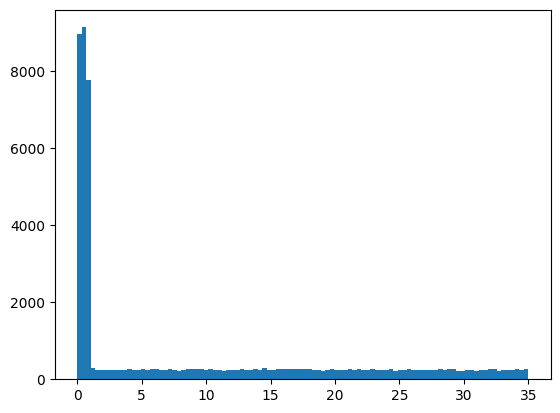

In [38]:
plt.hist(throttles_normal, bins=100)
plt.show()
plt.hist(steers_normal, bins=100)
plt.show()
plt.hist(speeds_normal, bins=100)
plt.show()